In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def get_all():
    fpath = '../congress-data/members/'
    files = os.listdir(fpath)
    house = set()
    senate = set()
    dem = set()
    rep = set()
    men = set()
    women = set()
    leaders = set()
    
    total_obs = 0
    
    for file in files:
        df = pd.read_csv(fpath+file, index_col=0)
        mem_id = df.loc[0]['id']
        
        total_obs += len(df)
        
        if df.loc[0]['gender'] == 'F':
            women.add(mem_id)
        else:
            men.add(mem_id)
            
        if len(df['chamber'].unique()) > 1:
            house.add(mem_id)
            senate.add(mem_id)
        elif df.loc[0]['chamber'].lower() == 'house':
            house.add(mem_id)
        else:
            senate.add(mem_id)
            
        if len(df['party'].unique()) > 1:
            rep.add(mem_id)
            dem.add(mem_id)
        elif df.loc[0]['party'] == 'D':
            dem.add(mem_id)
        else:
            rep.add(mem_id)
            
        for role in df['leadership_role']:
            if type(role) == str:
                leaders.add(df.loc[0]['id'])
                continue
    print('Total Observarions: %d' % total_obs)

    return house, senate, dem, rep, men, women, leaders

def get_ids(chamber, start_con, end_con, party=None):
    fpath = '../congress-data/members/'
    files = os.listdir(fpath)
    id_set = set()
    for file in files:
        df = pd.read_csv(fpath+file, index_col=0)
        
        sessions = df['congress'].values
        
        first_con = min(sessions)
        last_con = max(sessions)
        
        if first_con > end_con or last_con < start_con:
            continue
            
        if party != None:
            if (len(df['party'].unique()) > 1) or (df.loc[0]['party'] == party):
                id_set.add(df.loc[0]['id'])
                continue
        
        if (len(df['chamber'].unique()) > 1) or (df.loc[0]['chamber'].lower() == chamber):
            id_set.add(df.loc[0]['id'])
                
    return id_set

def get_csv(mem_id, to_drop):
    fpath = '../congress-data/members/'
    df = pd.read_csv(fpath+mem_id+'.csv', index_col=0)
    
    df.dropna(subset=to_drop, inplace=True)
    return df

In [3]:
(house, senate, dem, rep, men, women, leaders) = get_all()

Total Observarions: 12262


### Basic Stats

In [4]:
def missed_votes_5_num_sum(group_1, group_2, grouping, g1_filter, g2_filter, ylim):
    g1_missed_votes = []
    g2_missed_votes = []
    
    for mem_id in group_1:
        df = get_csv(mem_id, to_drop=['gender', 'total_votes', 
                  'missed_votes'])
        if len(df) == 0:
            continue
        
        df = df[df[grouping] == g1_filter]
        g1_missed_votes.extend(df['missed_votes'])
        
    for mem_id in group_2:
        df = get_csv(mem_id, to_drop=['gender', 'total_votes', 
                  'missed_votes'])
        if len(df) == 0:
            continue
        
        df = df[df[grouping] == g2_filter]
        g2_missed_votes.extend(df['missed_votes'])
        
    g1_quartiles = np.percentile(g1_missed_votes, [25, 50, 75])
    g2_quartiles = np.percentile(g2_missed_votes, [25, 50, 75])
    
    g1_min = np.min(g1_missed_votes)
    g1_max = np.max(g1_missed_votes)
    
    g2_min = np.min(g2_missed_votes)
    g2_max = np.max(g2_missed_votes)
    
    
    print('Comparing: %s' % (grouping))
    print('    | %s | %s |' % (g1_filter, g2_filter))
    print('Min:| %d | %d |' % (g1_min, g2_min))
    print('Q1: | %d | %d |' % (g1_quartiles[0], g2_quartiles[0]))
    print('Med:| %d | %d |' % (g1_quartiles[1], g2_quartiles[1]))
    print('Q3: | %d | %d |' % (g1_quartiles[2], g2_quartiles[2]))
    print('Max:| %d | %d |' % (g1_max, g2_max))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    sns.boxenplot(g1_missed_votes, ax=ax[0], orient='v')
    sns.boxenplot(g2_missed_votes, ax=ax[1], orient='v')


    #ax[0].boxplot(g1_missed_votes)
    #ax[1].boxplot(g2_missed_votes)
    ax[0].set_title('%s Missed Votes' % g1_filter)
    ax[1].set_title('%s Missed Votes' % g2_filter)
    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)

Comparing: party
    | D | R |
Min:| 0 | 0 |
Q1: | 13 | 12 |
Med:| 31 | 25 |
Q3: | 65 | 51 |
Max:| 1695 | 1594 |


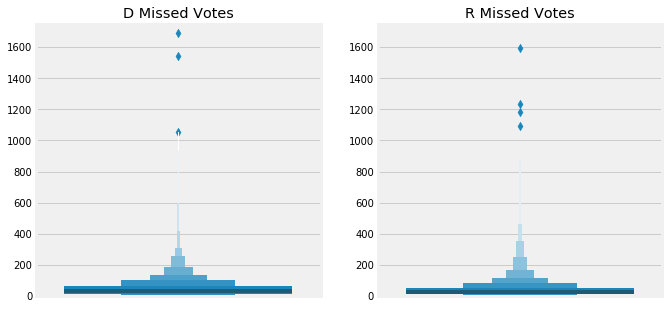

In [5]:
missed_votes_5_num_sum(dem, rep, 'party', 'D', 'R', ylim=(0, 1750))

We see that Democrats tend to have a slightly higher amount of missed votes than Republicans:

```
Comparing: party
    | D    | R    |
----+------+------+
Min:| 0    | 0    |
Q1: | 13   | 12   |
Med:| 32   | 26   |
Q3: | 66   | 52   |
Max:| 1695 | 1594 |
```

Comparing: gender
    | M | F |
Min:| 0 | 0 |
Q1: | 12 | 11 |
Med:| 27 | 31 |
Q3: | 57 | 65 |
Max:| 1594 | 1695 |


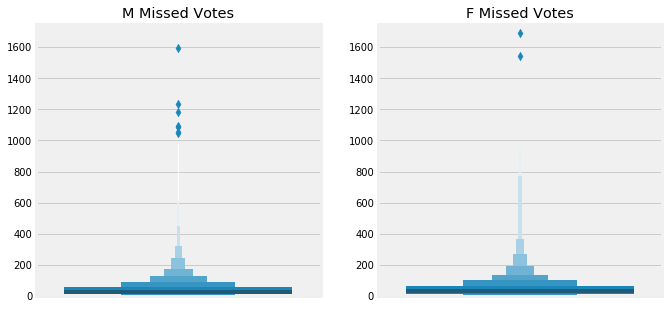

In [6]:
missed_votes_5_num_sum(men, women, 'gender', 'M', 'F', ylim=(0, 1750))


We see that women tend to have a slightly higher amount of missed votes than men:
```
Comparing: gender
    | M    | F    |
----+------+------+
Min:| 0    | 0    |
Q1: | 12   | 11   |
Med:| 28   | 32   |
Q3: | 58   | 65   |
Max:| 1594 | 1695 |
```

In [7]:
def sort_leaders(leaders):
    house_leaders = set()
    senate_leaders = set()
    for leader_id in leaders:
        mem_df = get_csv(leader_id, to_drop=['total_votes', 'missed_votes'])
        
        for idx, row in mem_df.iterrows():
            if row['chamber'] == 'House' and type(row['leadership_role']) == str:
                house_leaders.add(row['id'])
            elif row['chamber'] == 'Senate' and type(row['leadership_role']) == str:
                senate_leaders.add(row['id'])
    return house_leaders, senate_leaders
        
def leaders_5_num_sum(chamber_set, leaders, chamber, ylim):
    non_leader_missed_votes = []
    leader_missed_votes = []
    
    for mem_id in chamber_set:
        df = get_csv(mem_id, to_drop=['total_votes', 'missed_votes'])
        if len(df) == 0:
            continue
        
        df = df[df['chamber'] == chamber]
        df = df[df['leadership_role'].isnull()]
        non_leader_missed_votes.extend(df['missed_votes'])
        
    for mem_id in leaders:
        df = get_csv(mem_id, to_drop=['total_votes', 'missed_votes'])
        if len(df) == 0:
            continue
        
        df = df[df['chamber'] == chamber]
        df = df[~df['leadership_role'].isnull()]
        leader_missed_votes.extend(df['missed_votes'])
                
    non_leader_quartiles = np.percentile(non_leader_missed_votes, [25, 50, 75])
    leader_quartiles = np.percentile(leader_missed_votes, [25, 50, 75])
    
    non_leader_min = np.min(non_leader_missed_votes)
    non_leader_max = np.max(non_leader_missed_votes)
    
    leader_min = np.min(leader_missed_votes)
    leader_max = np.max(leader_missed_votes)
    
    
    print('Comparing: Leadership')
    print('    | Non-Leaders | Leaders |')
    print('Min:| %d | %d |' % (non_leader_min, leader_min))
    print('Q1: | %d | %d |' % (non_leader_quartiles[0], leader_quartiles[0]))
    print('Med:| %d | %d |' % (non_leader_quartiles[1], leader_quartiles[1]))
    print('Q3: | %d | %d |' % (non_leader_quartiles[2], leader_quartiles[2]))
    print('Max:| %d | %d |' % (non_leader_max, leader_max))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    sns.boxenplot(non_leader_missed_votes, ax=ax[0], orient='v')
    sns.boxenplot(leader_missed_votes, ax=ax[1], orient='v')

    ax[0].set_title('Non-Leader Missed Votes - %s' % chamber)
    ax[1].set_title('Leader Missed Votes - %s' % chamber)
    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)

In [8]:
house_leaders, senate_leaders = sort_leaders(leaders)

Comparing: Leadership
    | Non-Leaders | Leaders |
Min:| 0 | 0 |
Q1: | 16 | 28 |
Med:| 34 | 53 |
Q3: | 66 | 119 |
Max:| 947 | 1695 |


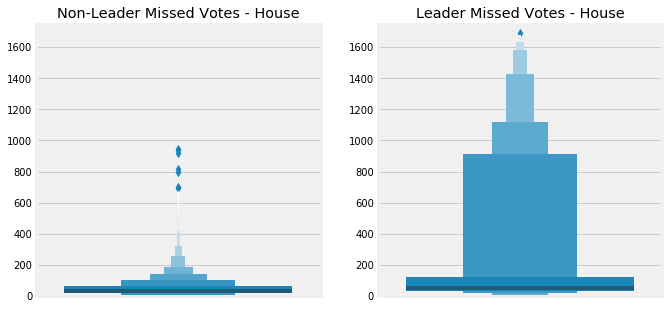

In [9]:
leaders_5_num_sum(house, house_leaders, 'House', ylim=(0,1750))

Comparing: Leadership
    | Non-Leaders | Leaders |
Min:| 0 | 0 |
Q1: | 4 | 1 |
Med:| 11 | 4 |
Q3: | 22 | 10 |
Max:| 488 | 201 |


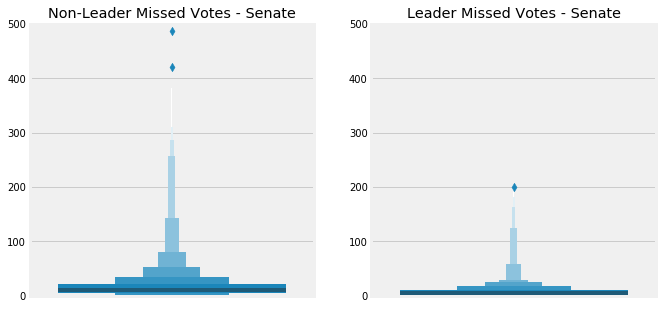

In [10]:
leaders_5_num_sum(senate, senate_leaders, 'Senate', ylim=(0,500))

### Plotting leaders' total missed votes over time

In [11]:
def plot_leaders(leader_ids, leader_roles):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    roles_added = set()
    blue_added = False
    red_added = False
    for leader_id in leader_ids:
        df = get_csv(leader_id, to_drop=['total_votes', 'missed_votes'])
        
        missed_votes = df['missed_votes']
        congress = df['congress']
        
        party = df['party'][0]
        if party == 'D':
            c = '#64B5F6'
            label = 'Democrat' if not blue_added else ''
            blue_added = True
        else:
            c = '#E57373'
            label = 'Republican' if not red_added else ''
            red_added = True
        
        ax.plot(congress, missed_votes, c=c, linewidth=1, label=label)
        
        for role in leader_roles:
            if role == 'Speaker of the House':
                c_ = '#7570b3'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            elif role == 'Majority Lead':
                c_ = '#1b9e77'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            elif role == 'Majority Whip':
                c_ = '#d95f02'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            elif role == 'Minority Lead':
                c_ = '#66a61e'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            elif role == 'Minority Whip':
                c_ = '#e6ab02'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            else:
                c_ = 'grey'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            
            role_missed = df[df['leadership_role'] == role]['missed_votes']
            role_session = df[df['leadership_role'] == role]['congress']
            
            ax.scatter(role_session, role_missed, c=c_, s=50, label=label_, edgecolor='black')
            
    ax.legend()  

In [12]:
def get_roles(leaders):
    house_roles = set()
    senate_roles = set()
    for ids in leaders:
        df = get_csv(ids, to_drop=['total_votes', 'missed_votes'])
        df = df[~df['leadership_role'].isnull()]

        for idx, row in df.iterrows():
            if row['chamber'] == 'House':
                house_roles.add(row['leadership_role'])
            else:
                senate_roles.add(row['leadership_role'])
    return house_roles, senate_roles

In [13]:
def get_ids_by_role(leaders, role):
    id_set = set()
    for ids in leaders:
        df = get_csv(ids, to_drop=['total_votes', 'missed_votes'])
        df = df[df['leadership_role'].isin(role)]
        
        if len(df) > 0:
            id_set.add(df['id'].values[0])
            
    return id_set

In [14]:
house_roles, senate_roles = get_roles(leaders)

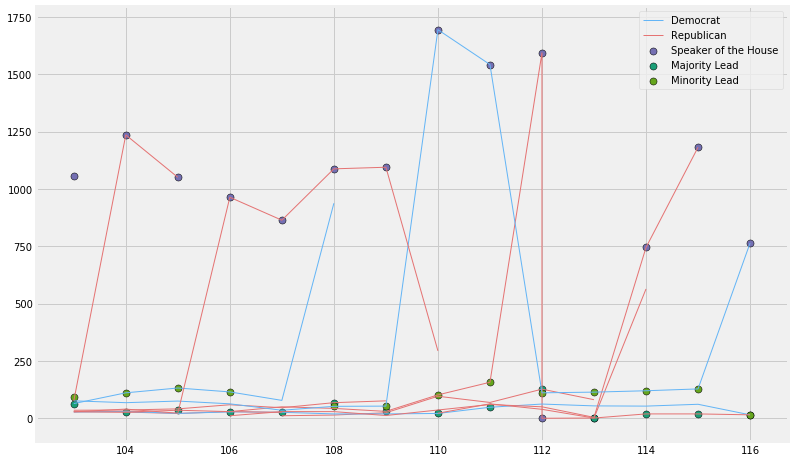

In [15]:
roles = ['Speaker of the House', 'Majority Lead', 'Minority Lead']
ids = get_ids_by_role(house_leaders, roles)
plot_leaders(ids, roles)

{'B000589', 'F000239', 'G000225', 'H000323', 'P000197', 'R000570'}

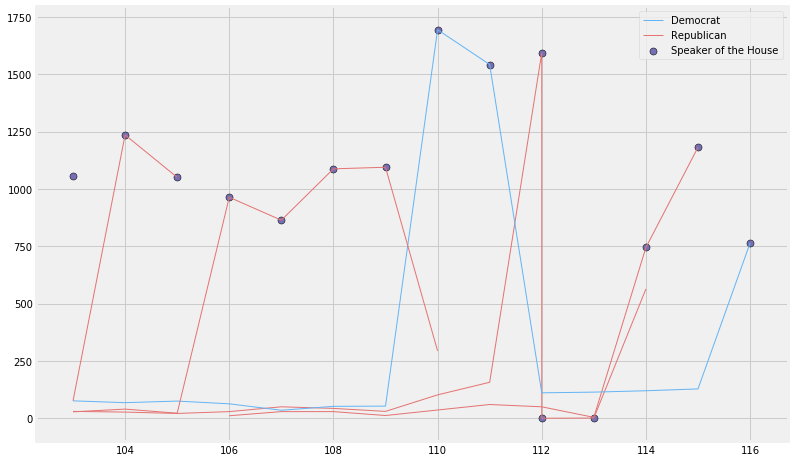

In [23]:
roles = ['Speaker of the House']
ids = get_ids_by_role(house_leaders, roles)
plot_leaders(ids, roles)
ids

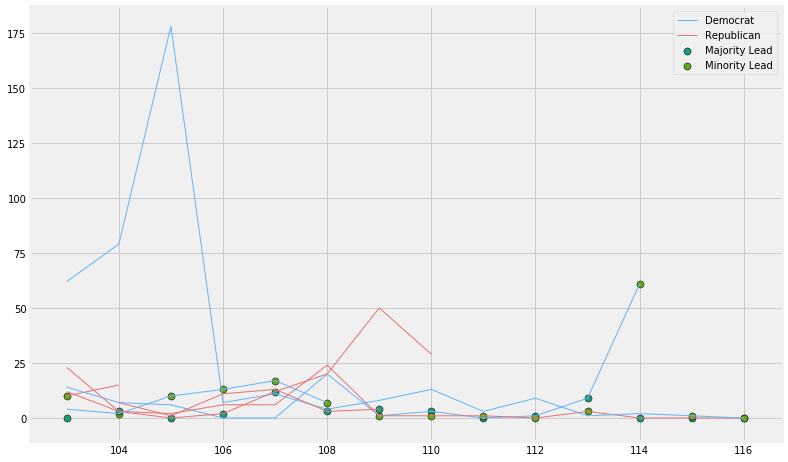

In [17]:
roles = ['Majority Lead', 'Minority Lead']
ids = get_ids_by_role(senate_leaders, roles)
plot_leaders(ids, roles)

### Need to look at committees now lol


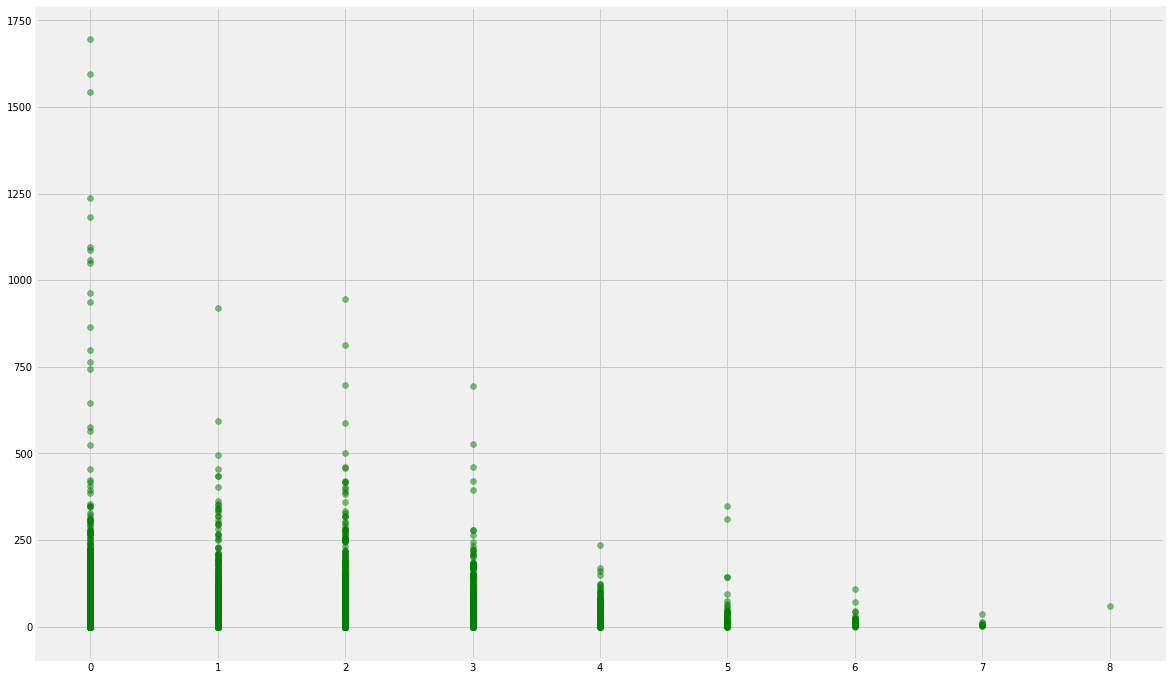

In [18]:
fig, ax = plt.subplots(figsize=(18,12))
for member in house:
    df = get_csv(member, to_drop=['total_votes', 'missed_votes', 'subcommittees', 'committees'])
    missed_votes = df['missed_votes']
    committees = df['committees']
    
    ax.scatter(committees, missed_votes, c='green', alpha=0.5)

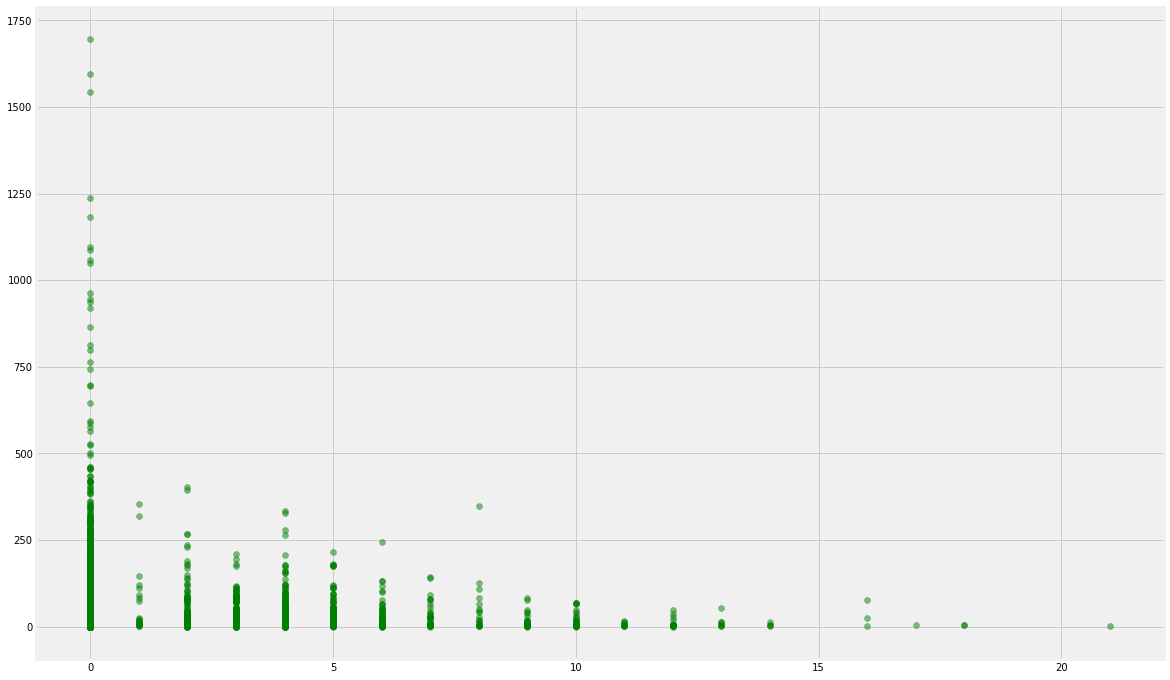

In [19]:
fig, ax = plt.subplots(figsize=(18,12))
for member in house:
    df = get_csv(member, to_drop=['total_votes', 'missed_votes', 'subcommittees', 'committees'])
    missed_votes = df['missed_votes']
    committees = df['subcommittees']
    
    ax.scatter(committees, missed_votes, c='green', alpha=0.5)

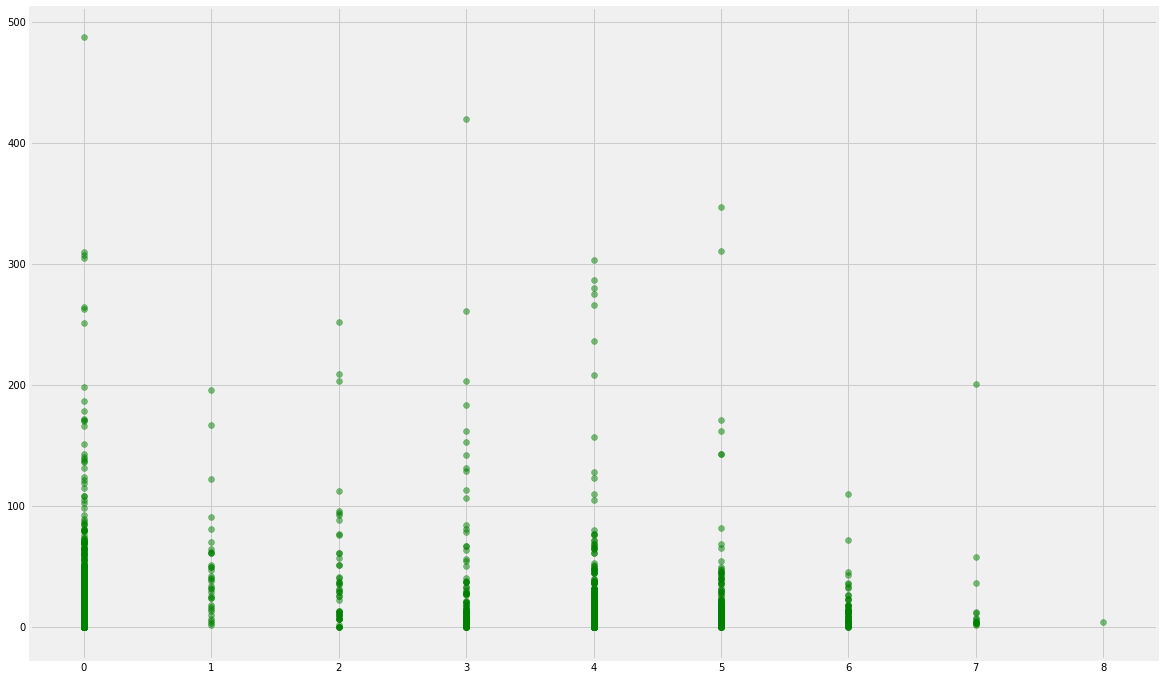

In [20]:
fig, ax = plt.subplots(figsize=(18,12))
for member in senate:
    df = get_csv(member, to_drop=['total_votes', 'missed_votes', 'subcommittees', 'committees'])
    missed_votes = df['missed_votes']
    committees = df['committees']
    
    ax.scatter(committees, missed_votes, c='green', alpha=0.5)

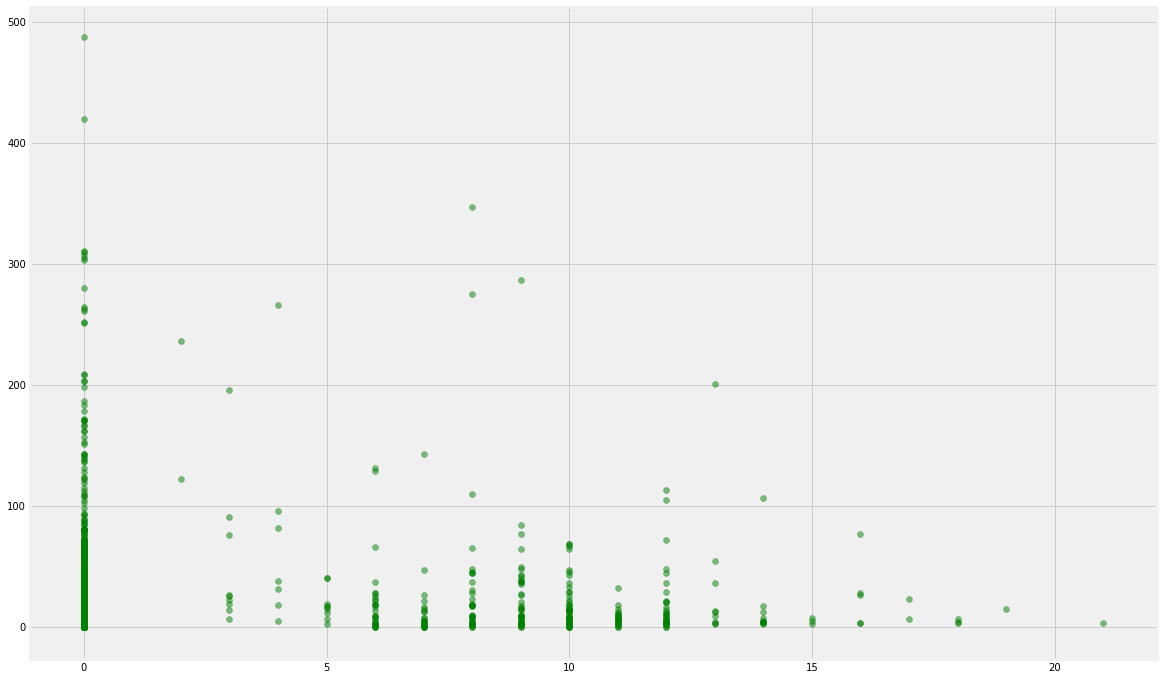

In [21]:
fig, ax = plt.subplots(figsize=(18,12))
for member in senate:
    df = get_csv(member, to_drop=['total_votes', 'missed_votes', 'subcommittees', 'committees'])
    missed_votes = df['missed_votes']
    committees = df['subcommittees']
    
    ax.scatter(committees, missed_votes, c='green', alpha=0.5)